# ДЕТЕКЦИЯ ПЕЧАТИ И ШТРИХ-КОДА

Данильченко Вадим

In [1]:
# !pip install opencv-contrib-python==3.2.0.7 opencv-python==3.2.0.7

In [1]:
%matplotlib inline
import numpy as np
import cv2, imutils
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array, load_img

## Загружаем изображения

In [3]:
from PIL import Image

In [4]:
!pip show opencv-python

Name: opencv-python
Version: 4.4.0.42
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: c:\users\vdanilchenko\test-env3\lib\site-packages
Requires: numpy
Required-by: 


Предположим, что имеется цветное изображение формата А4, на котором может быть одна или несколько круглых печатей. Поставим задачу — определить координаты прямоугольников, ограничивающих области изображения с оттисками печати. Эта задача является задачей детекции объектов (object detection), и для её решения можно использовать разные подходы. Применим подход на основе поиска контуров с помощью преобразования Хафа. Это подход удобно использовать, поскольку у нас есть некоторые априорные знания об искомых объектах: круглая форма, преимущественно синий цвет, определенный размер.

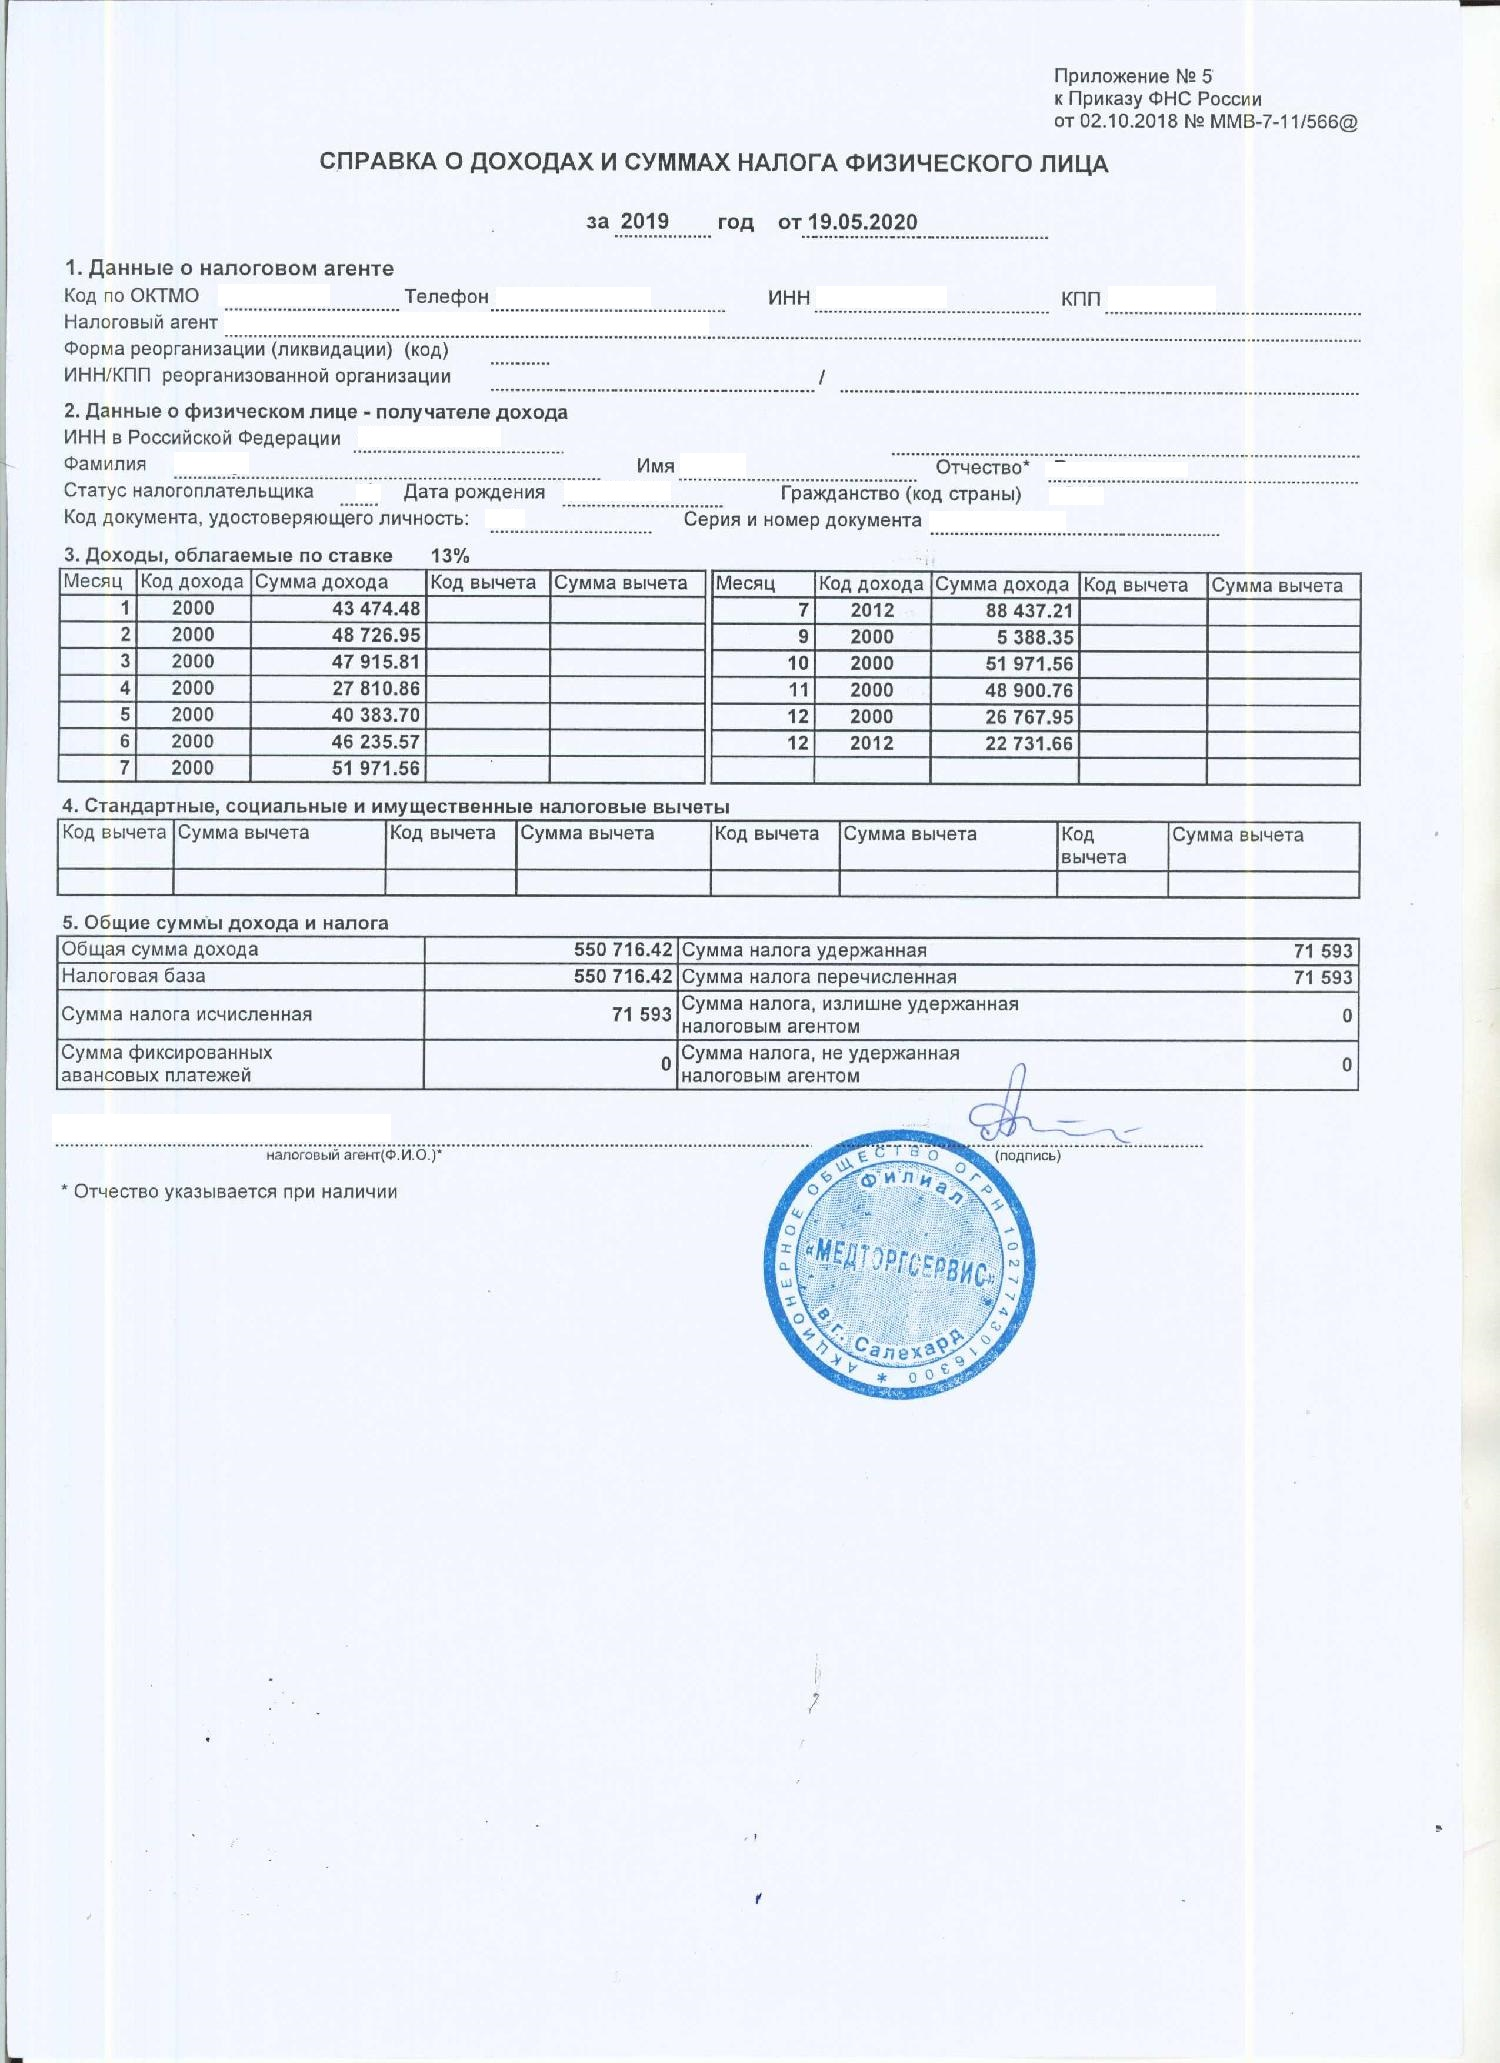

In [5]:
im = cv2.imread('2337444506_wo_personal.jpg')
load_img('2337444506_wo_personal.jpg')

In [6]:
im.shape

(2063, 1500, 3)

In [7]:
im.shape[1]/im.shape[0]

0.7270964614638875

In [8]:
# img = cv2.resize(im,(1500, int(im.shape[1] * im.shape[1]/im.shape[0])))
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.imshow('image',im)
cv2.waitKey(0)
cv2.destroyAllWindows()

 Выделяем области искомого цвета. Для этого преобразуем изображение из цветовой модели RGB в цветовую модель HSV (hue-saturation-value, или тон-насыщенность-значение). Если цветовую схему HSV представить в виде круга, где тон определяется углом от 0° до 360°, то можно обнаружить, что тон синей печати находится внутри сектора, приблизительно ограниченного значениями 160° и 280°.


С учетом того, что в соответствии с особенностями библиотеки opencv значение тона лежит в диапазоне от 0 до 180, выбранные нами границы примут значения 80 и 140 соответственно.

Выполняем преобразование изображения к цветовой модели HSV, задаём границы тона, насыщенности и значения, накладываем соответствующую маску на исходное изображение.

In [9]:
hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
blue_lower = np.array([80, 30, 30])
blue_higher = np.array([140, 250, 250])
mask = cv2.inRange(hsv, blue_lower, blue_higher)
selection = cv2.bitwise_and(im, im, mask=mask)

В результате изображение selection будет содержать только те области, цвет которых соответствует заданным нам ограничениям.

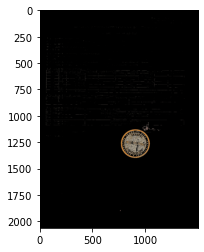

In [10]:
plt.imshow(selection)

In [11]:
# сохраним изображение
cv2.imwrite('2337444506_wo_personal_mask.jpg',selection)

True

Преобразуем цветное изображение в серое, затем выполняем сглаживание для коррекции мелких артефактов на изображении.

In [12]:
gray = cv2.cvtColor(selection, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 2)

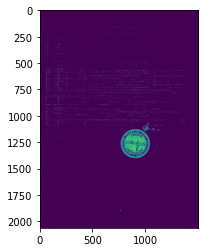

In [13]:
plt.imshow(blur)

Находим круглые контуры с помощью функции HoughCircles. Предварительно рассчитываем минимальный и максимальный радиусы искомых окружностей в пикселах, а также задаем параметр minDist (минимальное расстояние между центрами контуров) равным диаметру самой маленькой печати. Отметим, что согласно ГОСТ Р 51511-2001, диаметр гербовой печати составляет от 40 до 50 мм, или от 19% до 24% от ширины листа формата А4. С учетом небольшого запаса задаём относительные диаметра печатей от 0,15 до 0,30.

In [14]:
blur.shape

(2063, 1500)

In [15]:
h, w = gray.shape
r_min = int(w * 0.15 / 2)
r_max = int(w * 0.35 / 2)
# contours = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1, minDist=2 * r_min)
contours = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1,minRadius=0, maxRadius=0, minDist=2 * r_min)

In [16]:
r_min, r_max

(112, 262)

In [17]:
2 * r_min

224

In [18]:
contours

array([[[ 859.5, 1263.5,   56.1]]], dtype=float32)

В результате переменная contours будет содержать перечень координат центров и радиусов всех обнаруженных контуров

Составляем список ограничивающих прямоугольников boxes, для чего проходим в цикле по всем обнаруженным контурам, отбираем окружности подходящего радиуса и рассчитываем координаты противоположных углов ограничивающих прямоугольников.

In [19]:
boxes = []
if contours is not None:
    for contour in contours[0]:
        xc, yc, r = np.uint16(np.around(contour))
        if r_min <= r*2 <= r_max:
            x1 = int(xc - r*2)
            y1 = int(yc - r*2.5)
            x2 = int(xc + r*3)
            y2 = int(yc + r*2.5)
            print('was here')
            boxes.append([x1, y1, x2, y2])

was here


In [20]:
boxes

[[748, 1124, 1028, 1404]]

In [21]:
boxes[0][:2], np.around(boxes[0][2:])

([748, 1124], array([1028, 1404]))

In [22]:
tuple(boxes[0][:2])

(748, 1124)

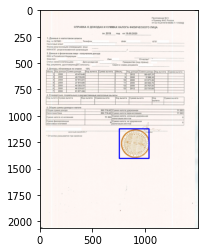

In [23]:
plt.imshow(cv2.rectangle(im, tuple(boxes[0][:2]), tuple(boxes[0][2:]), (0,0,255),10))

In [24]:
# сохраним изображение
cv2.imwrite('2337444506_wo_personal_rect.jpg', im)

True

# детекция баркода

In [40]:
img = cv2.imread('img_to_erode.jpg')

In [41]:
img = imutils.resize(img, width=1500)

In [42]:
gray_ = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, gray_ = cv2.threshold(gray_, 150, 255, cv2.THRESH_OTSU)

In [43]:
gray_ = cv2.erode(gray_, np.ones((3, 3), np.uint8), iterations=4)

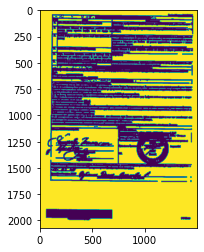

In [44]:
plt.imshow(gray_)

In [45]:
# cv2.imwrite('img_dilate.jpg', gray_)

In [46]:
contours, _ = cv2.findContours(gray_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rects = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    rect = (x, y, x + w, y + h)
    if 650 > w > 480 and 150 > h > 90 and y > 1700:
        rects.append(rect)
if rects:
    rect = max(rects, key=lambda x: x[1])

In [47]:
rect

(56, 1888, 687, 1997)

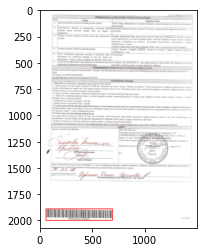

In [48]:
plt.imshow(cv2.rectangle(img, rect[:2], rect[2:], (255, 0, 0), 5))

# детекция подписи

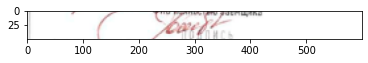

In [57]:
img_sign = img[1350:1400, 100:700]
plt.imshow(img_sign)

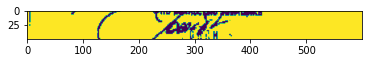

In [62]:
gray_scale = cv2.cvtColor(img_sign, cv2.COLOR_BGR2GRAY)
_, thresh_value = cv2.threshold(gray_scale, 150, 255, cv2.THRESH_OTSU)
plt.imshow(thresh_value)

In [63]:
zero_percent = np.count_nonzero(thresh_value) / (thresh_value.shape[0] * thresh_value.shape[1])
print('signature detected:', 1 - zero_percent>0.1)

signature detected: True
